# Event-shopping Likelihood Model

## Data exploration

#### In this notebook:
* ~~Download data file from S3 bucket and save locally~~
* Examine aggregate event-shopping-by-persona counts
* Read in a sample of the data set, taking an equal number from each persona 
* Save sample
* Scale and transform data
* Examine data

In [1]:
import os
import sys
import json
import time
import re
import gzip
import random

import numpy as np
import pandas as pd

In [2]:
from scipy.stats import chi2_contingency

#import statsmodels.api as sm 

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingRegressor
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn import metrics

In [4]:
#lib_path = os.path.abspath(os.path.join('..','lib'))
#sys.path.append(lib_path)
#import redshift_utils as rs
#import s3_utils as s3

In [11]:
key_event = 'anniversary_public'
key_year = 2017
key_event_slug = 'annpub17'

#### Download file from S3 bucket

In [4]:
handle = 'ep_anniversary_public_2017_20180308_'
#handle = 'ep_valentines_day_2017_20180307_'
filename = handle + '000.gz'
dl_path = os.path.join('temp','downloads')

In [35]:
#environment = 'local'
#bucket = 'liveramp-testing'
#s3_path = 'event_propensity/temp_data/'

In [36]:
#s3.download_file_from_s3(bucket, s3_path, filename, filepath=dl_path, environment=environment)

#### Examine distribution of personas in shopping events

In [8]:
distfile = 'event_shoppers_by_persona.csv'
qdf = pd.read_csv(os.path.join(dl_path, distfile))

In [20]:
#mdf = pd.melt(qdf, id_vars = ['persona','event','year'], value_vars=['n_shopped','n_existing'])

In [10]:
qdf['n_notshopped'] = qdf['n_existing'] - qdf['n_shopped']

In [10]:
gdf = qdf.groupby(['persona','year']).apply(lambda q: q[['n_shopped','n_existing']].values)
obs = np.array(gdf.groupby(level=0).agg(lambda s: s.tolist()).tolist())
chi2, p, dof, expected = chi2_contingency(obs)
print chi2, p, dof

82526344.46280143 0.0 677


In [11]:
gdf = qdf.groupby(['persona','event'])[['n_shopped','n_notshopped']].sum()
obs = np.array(gdf.groupby(level=0).apply(lambda s: s.values).tolist())
chi2, p, dof, expected = chi2_contingency(obs)
print chi2, p, dof

65255481.598253205 0.0 121


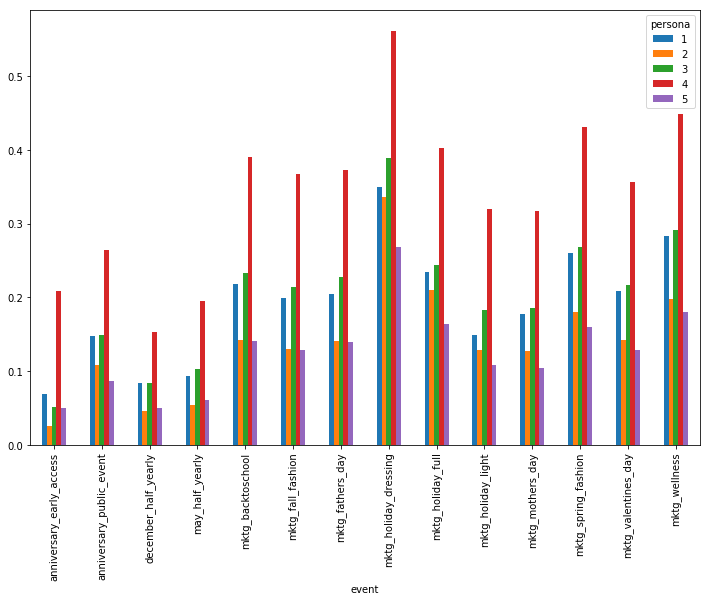

In [15]:
gdf = qdf.groupby(['persona','event'])[['n_shopped','n_existing']].sum()
gdf['pct_shopped'] = gdf['n_shopped']/gdf['n_existing']
pvt = gdf.reset_index().pivot(index='event', columns='persona', values='pct_shopped')
pvt.plot.bar()

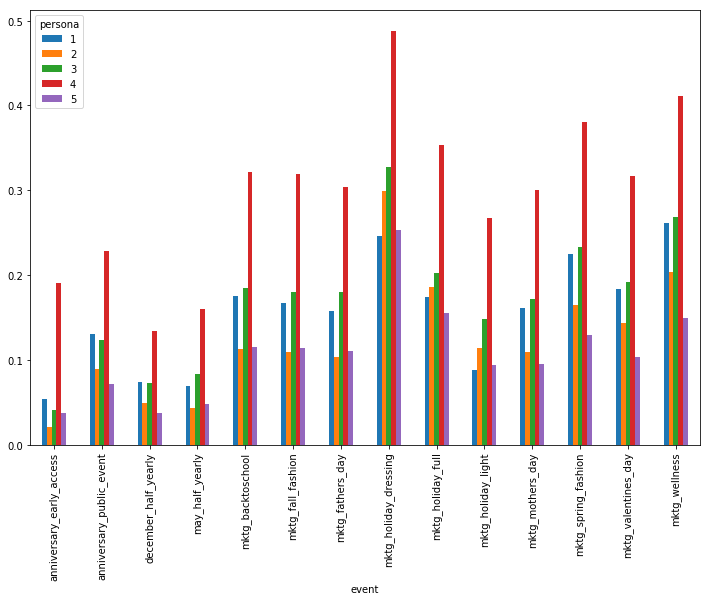

In [14]:
gdf = qdf.loc[qdf['year']==2017].drop('year', axis=1).set_index(['persona','event'])#qdf.groupby(['persona','event'])[['n_shopped','n_existing']].sum()
gdf['pct_shopped'] = gdf['n_shopped']/gdf['n_existing']
pvt = gdf.reset_index().pivot(index='event', columns='persona', values='pct_shopped')
pvt.plot.bar()

#### Get distributed random sample of downloaded customer data

In [5]:
%%time

np.random.seed(30132)
n_sample = 250000
grp_col = 'persona'
tgt_col = 'target_shopped_ind'
grp_ord = []
grp_cts = []
tgt_cts = []
#t0 = time.time()
with gzip.open(os.path.join(dl_path,filename),'rb') as f: 
    header = f.readline().strip().split('|')
    ix = header.index(grp_col)
    jx = header.index(tgt_col)
    kx = max(ix,jx)
    for row in f:
        row = row.split('|',kx+1)
        g = row[ix]
        t = row[jx]
        if len(grp_ord) == 0 or g != grp_ord[-1]:
            grp_ord.append(g)
            grp_cts.append(0)
            tgt_cts.append(0)
        grp_cts[-1] += 1
        tgt_cts[-1] += int(t)
    n_each = n_sample/len(grp_ord)
    skip = np.concatenate(map(lambda n,o: o - np.random.choice(n, n-n_each, replace=False), 
                              grp_cts, np.cumsum(grp_cts)))
    skip.sort()
    f.seek(0)
    df = pd.read_csv(f, header=0, delimiter='|', skiprows=skip)
#print time.time() - t0

CPU times: user 3min 42s, sys: 4.44 s, total: 3min 47s
Wall time: 3min 50s


In [12]:
xdf = pd.DataFrame({'n': grp_cts, 'n_pos': tgt_cts}, index=map(int, grp_ord)).sort_index()
xdf.index.name = 'persona'
xdf.to_csv('../data/ep_{0}_data_summary.csv'.format(key_event_slug), index=True)
xdf['pct'] = xdf['n_pos']/xdf['n']
xdf

,n,n_pos,pct
persona,,,
1,1766814,169019,0.095663
2,2188483,110209,0.050359
3,7760758,843944,0.108745
4,3899887,888168,0.227742
5,1748052,115534,0.066093


In [7]:
gdf = df.groupby('persona')['target_shopped_ind'].agg(['count','sum'])
gdf['pct'] = gdf['sum']/gdf['count']
gdf

,count,sum,pct
persona,,,
1,50000,4837,0.09674
2,50000,2517,0.05034
3,50000,5505,0.11010
4,50000,11322,0.22644
5,50000,3297,0.06594


In [ ]:
xdf = pd.DataFrame({'n': grp_cts, 'n_pos': tgt_cts}, index=map(int, grp_ord)).sort_index()


In [3]:
np.random.seed(301320)
n_sample = 50000
t0 = time.time()
with gzip.open(os.path.join(dl_path,filename),'rb') as f:
    n_rows = sum(1 for row in f) - 1
    skip = np.random.choice(n_rows, n_rows-n_sample, replace=False) + 1
    skip.sort()
    f.seek(0)
    df = pd.read_csv(f, header=0, delimiter='|', skiprows=skip)
print time.time() - t0

152.92937994


In [17]:
np.random.seed(301320)
n_sample = 50000
t0 = time.time()
with gzip.open(os.path.join(dl_path,filename),'rb') as f:
    n_rows = sum(1 for row in f) - 1
skip = np.random.choice(n_rows, n_rows-n_sample, replace=False) + 1
skip.sort()
df2 = pd.read_csv(os.path.join(dl_path,filename), header=0, delimiter='|', compression='gzip', skiprows=skip)
print time.time() - t0

171.072607994


In [30]:
df.columns

Index([u'cust_key', u'persona', u'target_shopped_ind', u'tenure_total_months',
       u'loyalty_tender_ind', u'loyalty_nontender_ind', u'fl_total_spend',
       u'fl_total_trips', u'fl_avg_spend_per_trip', u'sale_pct_items',
       u'merch_pct_spend', u'womens_prod_pct_spend', u'mens_prod_pct_spend',
       u'web_pct_spend', u'rack_pct_spend', u'fl_total_divs',
       u'total_channels', u'months_since_last_sale', u'fl_shopped_ly_ind',
       u'fl_total_spend_ly', u'anniversary_early_pct_spend',
       u'anniversary_public_pct_spend', u'december_halfyear_pct_spend',
       u'may_halfyear_pct_spend', u'wellness_pct_spend',
       u'spring_fashion_pct_spend', u'fall_fashion_pct_spend',
       u'holiday_light_pct_spend', u'holiday_full_pct_spend',
       u'backtoschool_pct_spend', u'holiday_dressing_pct_spend',
       u'valentines_day_pct_spend', u'mothers_day_pct_spend',
       u'fathers_day_pct_spend', u'anniversary_early_pct_shopped',
       u'anniversary_public_pct_shopped', u'december

In [31]:
df.dtypes

cust_key                            int64
persona                             int64
target_shopped_ind                  int64
tenure_total_months               float64
loyalty_tender_ind                  int64
loyalty_nontender_ind               int64
fl_total_spend                    float64
fl_total_trips                      int64
fl_avg_spend_per_trip             float64
sale_pct_items                    float64
merch_pct_spend                   float64
womens_prod_pct_spend             float64
mens_prod_pct_spend               float64
web_pct_spend                     float64
rack_pct_spend                    float64
fl_total_divs                       int64
total_channels                      int64
months_since_last_sale            float64
fl_shopped_ly_ind                   int64
fl_total_spend_ly                 float64
anniversary_early_pct_spend       float64
anniversary_public_pct_spend      float64
december_halfyear_pct_spend       float64
may_halfyear_pct_spend            

In [20]:
for col in df.columns.tolist()[3:]:
    print col, df[col].min(), df[col].max()

tenure_total_months 0.032258064516129 107.741935483871
loyalty_tender_ind 0 1
loyalty_nontender_ind 0 1
fl_total_spend 0.01 826182.03
fl_total_trips 1 1066
fl_avg_spend_per_trip 0.01 12201.3833333333
sale_pct_items 0.0 100.0
merch_pct_spend 3.38129235675715 100.0
womens_prod_pct_spend 0.0 100.0
mens_prod_pct_spend 0.0 100.0
web_pct_spend 0.0 100.0
rack_pct_spend 0.0 99.9418268378874
fl_total_divs 1 16
total_channels 1 3
months_since_last_sale 0.032258064516129 24.0
fl_shopped_ly_ind 0 1
fl_total_spend_ly 0.0 441365.48
anniversary_early_pct_spend 0.0 100.0
anniversary_public_pct_spend 0.0 100.0
december_halfyear_pct_spend 0.0 100.0
may_halfyear_pct_spend 0.0 100.0
wellness_pct_spend 0.0 100.0
spring_fashion_pct_spend 0.0 100.0
fall_fashion_pct_spend 0.0 100.0
holiday_light_pct_spend 0.0 100.0
holiday_full_pct_spend 0.0 100.0
backtoschool_pct_spend 0.0 100.0
holiday_dressing_pct_spend 0.0 100.0
valentines_day_pct_spend 0.0 100.0
mothers_day_pct_spend 0.0 100.0
fathers_day_pct_spend 0.0 1

In [21]:
(df.isnull().sum() > 0).any()

False

In [22]:
def transform_data(df, features, log_features, log_offset=0):
    nonfeatures = [c for c in df.columns if c not in features]
    df_t = pd.DataFrame(df[nonfeatures].values, columns=nonfeatures)
    for col in features:
        dcol = df[col].astype('float64')
        if col in log_features:
            dcol.loc[dcol <= 0] = log_offset
            dcol.loc[dcol > 0] = np.log(dcol.loc[dcol > 0])
        if re.search('_pct_',col) is not None:
            df_t[col] = dcol/100.0
        elif re.search('_ind$',col) is not None:
            df_t[col] = dcol.astype('int64')
        elif re.search('months',col) is not None:
            df_t[col] = dcol
        else:
            df_t[col] = (dcol - dcol.min())/(dcol.max() - dcol.min())
    return df_t

In [23]:
features = df.columns.tolist()[3:]
target = 'target_shopped_ind'
log_features = ['fl_total_spend','fl_total_trips','fl_avg_spend_per_trip','fl_total_spend_ly', 'fl_total_trips_ly','fl_avg_spend_per_trip_ly']
tdf = transform_data(df, features, log_features, -0.5)
tdf['tenure_total_months'] = tdf['tenure_total_months'].map(lambda t: 1 if t > 96 else t/96)
tdf['months_since_last_sale'] = tdf['months_since_last_sale']/24

In [24]:
tdf.dtypes

cust_key                            int64
persona                             int64
target_shopped_ind                  int64
tenure_total_months               float64
loyalty_tender_ind                  int64
loyalty_nontender_ind               int64
fl_total_spend                    float64
fl_total_trips                    float64
fl_avg_spend_per_trip             float64
sale_pct_items                    float64
merch_pct_spend                   float64
womens_prod_pct_spend             float64
mens_prod_pct_spend               float64
web_pct_spend                     float64
rack_pct_spend                    float64
fl_total_divs                     float64
total_channels                    float64
months_since_last_sale            float64
fl_shopped_ly_ind                   int64
fl_total_spend_ly                 float64
anniversary_early_pct_spend       float64
anniversary_public_pct_spend      float64
december_halfyear_pct_spend       float64
may_halfyear_pct_spend            

In [25]:
(tdf.isnull().sum() > 0).any()

False

In [26]:
for col in features:
    print col, tdf[col].min(), tdf[col].max()

tenure_total_months 0.00033602150537634373 1.0
loyalty_tender_ind 0 1
loyalty_nontender_ind 0 1
fl_total_spend 0.0 1.0
fl_total_trips 0.0 1.0
fl_avg_spend_per_trip 0.0 1.0
sale_pct_items 0.0 1.0
merch_pct_spend 0.0338129235675715 1.0
womens_prod_pct_spend 0.0 1.0
mens_prod_pct_spend 0.0 1.0
web_pct_spend 0.0 1.0
rack_pct_spend 0.0 0.999418268378874
fl_total_divs 0.0 1.0
total_channels 0.0 1.0
months_since_last_sale 0.001344086021505375 1.0
fl_shopped_ly_ind 0 1
fl_total_spend_ly 0.0 1.0
anniversary_early_pct_spend 0.0 1.0
anniversary_public_pct_spend 0.0 1.0
december_halfyear_pct_spend 0.0 1.0
may_halfyear_pct_spend 0.0 1.0
wellness_pct_spend 0.0 1.0
spring_fashion_pct_spend 0.0 1.0
fall_fashion_pct_spend 0.0 1.0
holiday_light_pct_spend 0.0 1.0
holiday_full_pct_spend 0.0 1.0
backtoschool_pct_spend 0.0 1.0
holiday_dressing_pct_spend 0.0 1.0
valentines_day_pct_spend 0.0 1.0
mothers_day_pct_spend 0.0 1.0
fathers_day_pct_spend 0.0 1.0
anniversary_early_pct_shopped 0.0 1.0
anniversary_publi

In [27]:
df.to_csv('../data/ep_{0}_unscaled_sample.csv.gz'.format(key_event_slug), index=False, sep='|', compression='gzip')
tdf.to_csv('../data/ep_{0}_scaled_sample.csv.gz'.format(key_event_slug), index=False, sep='|', compression='gzip')

In [27]:
#df.to_csv('../data/ep_annpub17_unscaled_sample.csv.gz', index=False, sep='|', compression='gzip')
#tdf.to_csv('../data/ep_annpub17_scaled_sample.csv.gz', index=False, sep='|', compression='gzip')

In [28]:
#df.to_csv('../data/ep_valent17_unscaled_sample.csv.gz', index=False, sep='|', compression='gzip')
#tdf.to_csv('../data/ep_valent17_scaled_sample.csv.gz', index=False, sep='|', compression='gzip')

In [120]:
features = tdf.columns.tolist()[3:]
print len(features)
features = [c for c in features if not c.startswith('wellness_pct_')]
features = [c for c in features if not c.startswith('holiday_dressing_pct_')]
features = [c for c in features if not c.startswith('fall_fashion_pct_')]
#features = [c for c in features if c != 'fl_total_spend_ly']
#features = [c for c in features if c != 'fl_total_divs']
#features = [c for c in features if c not in ['womens_prod_pct_spend','rack_pct_items','merch_pct_items','fl_total_items']]
#features = [c for c in features if not c.endswith('_prod_pct_items')]
#features = [c for c in features if not c.endswith('_pct_trips')]
print len(features)
corrs = tdf[features].corr().abs().unstack().sort_values(ascending=False)
corrs.loc[(corrs < 1)&(corrs >= 0.5)]

65
56


fl_total_spend_ly                fl_avg_spend_per_trip_ly           0.935174
fl_avg_spend_per_trip_ly         fl_total_spend_ly                  0.935174
                                 merch_pct_spend_ly                 0.894395
merch_pct_spend_ly               fl_avg_spend_per_trip_ly           0.894395
fl_total_spend                   fl_total_trips                     0.884944
fl_total_trips                   fl_total_spend                     0.884944
fl_total_divs                    fl_total_trips                     0.881932
fl_total_trips                   fl_total_divs                      0.881932
fl_total_divs_ly                 fl_total_trips_ly                  0.863723
fl_total_trips_ly                fl_total_divs_ly                   0.863723
mens_prod_pct_spend_ly           mens_prod_pct_spend                0.826123
mens_prod_pct_spend              mens_prod_pct_spend_ly             0.826123
merch_pct_spend_ly               fl_total_spend_ly                  0.820056

In [20]:
p = 5
features = tdf.columns.tolist()[3:]
print len(features)
#features = [c for c in features if not c.startswith('wellness_pct_')]
#features = [c for c in features if not c.startswith('holiday_dressing_pct_')]
#features = [c for c in features if not c.startswith('fall_fashion_pct_')]
#features = [c for c in features if c != 'fl_total_spend_ly']
#features = [c for c in features if c != 'fl_total_divs']
#features = [c for c in features if c not in ['womens_prod_pct_spend','rack_pct_items','merch_pct_items','fl_total_items']]
#features = [c for c in features if not c.endswith('_prod_pct_items')]
#features = [c for c in features if not c.endswith('_pct_trips')]
print len(features)
corrs = tdf.loc[tdf['persona']==p,features].corr().abs().unstack().sort_values(ascending=False)
corrs.loc[(corrs < 1)&(corrs >= 0.8)].head(60)

67
67


fl_total_spend_ly            fl_avg_spend_per_trip_ly       0.971832
fl_avg_spend_per_trip_ly     fl_total_spend_ly              0.971832
merch_pct_spend_ly           fl_avg_spend_per_trip_ly       0.935490
fl_avg_spend_per_trip_ly     merch_pct_spend_ly             0.935490
fl_total_spend_ly            merch_pct_spend_ly             0.904551
merch_pct_spend_ly           fl_total_spend_ly              0.904551
womens_prod_pct_spend        mens_prod_pct_spend            0.868479
mens_prod_pct_spend          womens_prod_pct_spend          0.868479
valentines_day_pct_spend_ly  wellness_pct_spend_ly          0.861605
wellness_pct_spend_ly        valentines_day_pct_spend_ly    0.861605
fl_total_divs                fl_total_trips                 0.854338
fl_total_trips               fl_total_divs                  0.854338
fl_total_divs_ly             fl_total_trips_ly              0.846601
fl_total_trips_ly            fl_total_divs_ly               0.846601
valentines_day_pct_shopped   welln

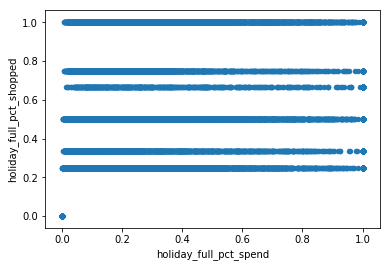

In [19]:
tdf.plot(x='holiday_full_pct_spend', y='holiday_full_pct_shopped', kind='scatter')

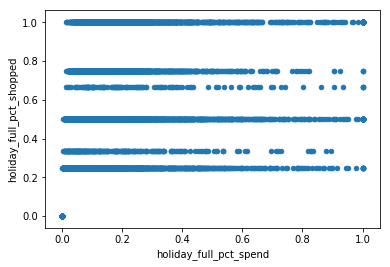

In [31]:
tdf.loc[tdf['persona']==4].plot(x='holiday_full_pct_spend', y='holiday_full_pct_shopped', kind='scatter')

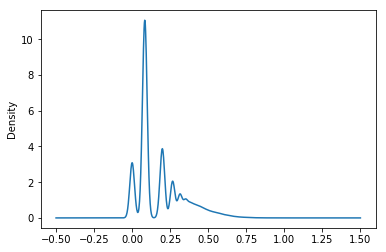

In [118]:
tdf['fl_total_trips_ly'].plot.kde()

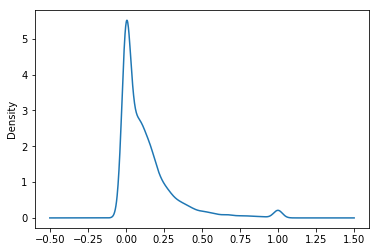

In [21]:
tdf.loc[tdf['persona']==4]['holiday_full_pct_spend'].plot.kde()

In [22]:
target = 'target_shopped_ind'
tdf[target].value_counts()

0    50507
1     9493
Name: target_shopped_ind, dtype: int64

In [23]:
group = 'persona'
group_vals = sorted(tdf[group].unique())
tdf[group].value_counts()

5    12000
4    12000
3    12000
2    12000
1    12000
Name: persona, dtype: int64

In [43]:
def grouped_model_scores(grp, features, target, model, train_size=0.7, split_state=8379, **kwargs):
    X_trn, X_tst, y_trn, y_tst = train_test_split(grp[features], grp[target], train_size=train_size, 
                                                  random_state=split_state, stratify=grp[target])
    mdl = model(**kwargs)
    mdl.fit(X_trn, y_trn)
    preds = mdl.predict(X_tst)
    pred_probs =  mdl.predict_proba(X_tst)[:,1]
    ser = pd.Series([len(grp), 
                     1-y_tst.sum()/float(len(y_tst)), 
                     metrics.accuracy_score(y_tst, preds), 
                     metrics.precision_score(y_tst, preds), 
                     metrics.recall_score(y_tst, preds), 
                     metrics.roc_auc_score(y_tst, pred_probs), 
                     mdl.oob_score_], 
                    index=['n','null_accuracy','accuracy','precision','recall','roc_auc','oob_score'])
    return ser

In [41]:
tdf.groupby(group).apply(lambda g: grouped_model_scores(g, features, target, RandomForestClassifier, 
                                                        random_state=202741, oob_score=True, 
                                                        n_estimators=100, max_depth=12))

,n,null_accuracy,accuracy,precision,recall,roc_auc,oob_score
persona,,,,,,,
1,26518.0,0.809326,0.828306,0.638532,0.229400,0.774930,0.826420
2,1010.0,0.874587,0.877888,0.526316,0.263158,0.861221,0.871287
3,12058.0,0.862908,0.873687,0.672566,0.153226,0.767704,0.868365
4,7186.0,0.720779,0.801948,0.721519,0.473422,0.801560,0.792445
5,3228.0,0.900929,0.909185,0.722222,0.135417,0.777700,0.906596


In [44]:
def grouped_feature_importances(grp, features, target, train_size=0.7, split_state=8379, **kwargs):
    X_trn, X_tst, y_trn, y_tst = train_test_split(grp[features], grp[target], train_size=train_size, 
                                                  random_state=split_state, stratify=grp[target])
    mdl = RandomForestClassifier(**kwargs)
    mdl.fit(X_trn, y_trn)
    ser = pd.Series(mdl.feature_importances_, index=features)
    return ser

In [50]:
fdf = tdf.groupby(group).apply(lambda g: grouped_feature_importances(g, features, target,  
                                                                     random_state=202741, oob_score=True, 
                                                                     n_estimators=100, max_depth=12))

In [57]:
35 - fdf.T.apply('rank')

persona,1,2,3,4,5
tenure_total_months,4.0,3.0,3.0,7.0,3.0
loyalty_tender_ind,32.0,32.0,34.0,32.0,32.0
loyalty_nontender_ind,33.0,12.0,30.0,34.0,33.0
fl_total_spend,2.0,1.0,2.0,2.0,2.0
fl_avg_spend_per_trip,5.0,4.0,4.0,6.0,4.0
fl_total_trips_ly,1.0,2.0,1.0,1.0,1.0
sale_pct_items,9.0,5.0,6.0,10.0,8.0
merch_pct_spend,26.0,34.0,21.0,28.0,27.0
mens_prod_pct_spend,19.0,11.0,15.0,17.0,11.0
web_pct_spend,3.0,28.0,9.0,20.0,26.0


In [46]:
def grouped_models(grp, features, target, model, train_size=0.7, split_state=8379, **kwargs):
    X_trn, X_tst, y_trn, y_tst = train_test_split(grp[features], grp[target], train_size=train_size, 
                                                  random_state=split_state, stratify=grp[target])
    mdl = model(**kwargs)
    mdl.fit(X_trn, y_trn)
    return mdl

In [48]:
mdls = tdf.groupby(group).apply(lambda g: grouped_models(g, features, target, RandomForestClassifier, 
                                                         random_state=202741, oob_score=True, 
                                                         n_estimators=100, max_depth=12))

In [59]:
mdls.loc[1]

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=202741, verbose=0,
            warm_start=False)

#### Persona \#1

In [20]:
g = 1
pdf1 = tdf.loc[tdf[group]==g]

In [21]:
pdf1[target].value_counts()

0    21463
1     5055
Name: target_shopped_ind, dtype: int64

In [22]:
X_trn, X_tst, y_trn, y_tst = train_test_split(pdf1[features], pdf1[target], train_size=0.7, 
                                              random_state=8379, stratify=pdf1[target])

/Users/c01f/.virtualenvs/devel/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [23]:
X_trn.head()

,tenure_total_months,loyalty_tender_ind,loyalty_nontender_ind,fl_total_spend,fl_avg_spend_per_trip,fl_total_trips_ly,sale_pct_items,merch_pct_spend,mens_prod_pct_spend,web_pct_spend,...,anniversary_public_pct_shopped,december_halfyear_pct_shopped,may_halfyear_pct_shopped,spring_fashion_pct_shopped,holiday_light_pct_shopped,holiday_full_pct_shopped,backtoschool_pct_shopped,valentines_day_pct_shopped,mothers_day_pct_shopped,fathers_day_pct_shopped
33947,0.599577,0.0,0.0,0.624794,0.369123,0.039801,0.357143,0.943578,0.058801,0.019061,...,0.50,0.75,0.25,1.00,0.25,1.00,0.75,1.0,1.00,1.00
40560,0.001511,0.0,1.0,0.183149,0.267876,0.002488,0.000000,1.000000,0.000000,1.000000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
28882,0.454518,0.0,0.0,0.478615,0.530057,0.002488,0.285714,1.000000,0.000000,1.000000,...,0.25,0.00,0.00,0.00,0.00,0.00,0.25,0.0,0.25,0.00
17842,0.766395,0.0,0.0,0.746143,0.616675,0.034826,0.100000,0.999407,0.039965,0.118978,...,0.00,0.00,0.25,0.50,0.50,0.75,0.25,0.0,0.75,0.25
3924,0.474766,0.0,0.0,0.547470,0.506734,0.024876,0.176471,1.000000,0.070137,0.486259,...,0.00,0.25,0.00,0.25,0.00,0.25,0.25,0.0,0.25,0.25


In [24]:
print 'df size:\t', len(pdf1)
print 'train size:\t', len(X_trn), len(y_trn)
print 'test size:\t', len(X_tst), len(y_tst)

df size:	26518
train size:	18562 18562
test size:	7956 7956


In [25]:
model = RandomForestClassifier(random_state=202741, oob_score=True, n_estimators=100, max_depth=12)
model.fit(X_trn, y_trn)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=202741, verbose=0,
            warm_start=False)

In [26]:
model.predict_proba(X_tst)

array([[0.71297694, 0.28702306],
       [0.90479952, 0.09520048],
       [0.78538687, 0.21461313],
       ...,
       [0.76918737, 0.23081263],
       [0.54118935, 0.45881065],
       [0.94219071, 0.05780929]])

In [27]:
predictions = model.predict(X_tst)
pred_probs = model.predict_proba(X_tst)[:,1]

In [28]:
c = metrics.confusion_matrix(y_tst, predictions)

print 'Estimated accuracy when generalized to test data: ', model.oob_score_
print 'Accuracy:\t', metrics.accuracy_score(y_tst, predictions)
print 'Precision:\t', metrics.precision_score(y_tst, predictions)
print 'Recall:\t', metrics.recall_score(y_tst, predictions)
print 'ROC AUC score:\t', metrics.roc_auc_score(y_tst, pred_probs)
print 
print c

Estimated accuracy when generalized to test data:  0.8264195668570197
Accuracy:	0.8283056812468578
Precision:	0.6385321100917432
Recall:	0.22940013183915622
ROC AUC score:	0.7749298395172053

[[6242  197]
 [1169  348]]


In [29]:
print 1-y_tst.sum()/float(len(y_tst))

0.8093262946204123


In [115]:
percentile_cutoff = np.percentile(pred_probs, 95)
predictions2 = (pred_probs >= percentile_cutoff).astype('int64')

In [120]:
c = metrics.confusion_matrix(y_tst, predictions2)

print 'Accuracy:\t', metrics.accuracy_score(y_tst, predictions2)
print 'Precision:\t', metrics.precision_score(y_tst, predictions2)
print 'Recall:\t', metrics.recall_score(y_tst, predictions2)
print 'ROC_AUC score:\t', metrics.roc_auc_score(y_tst, pred_probs)
print 
print c

Accuracy:	0.821751128951
Precision:	0.565011820331
Recall:	0.161924119241
ROC_AUC score:	0.737878145984

[[6312  184]
 [1237  239]]


In [30]:
for imp, feat in sorted(zip(model.feature_importances_, features))[::-1]:
    print feat, imp

fl_total_trips_ly 0.12131307841503494
fl_total_spend 0.1014785543593722
web_pct_spend 0.055607141710274144
tenure_total_months 0.045136908304370324
fl_avg_spend_per_trip 0.04275846041546455
holiday_full_pct_spend 0.03988372518494869
holiday_light_pct_spend 0.038624004512129835
backtoschool_pct_spend 0.03488707864375988
sale_pct_items 0.03317545214637543
valentines_day_pct_shopped 0.03239676205887942
valentines_day_pct_spend 0.03182675825035139
december_halfyear_pct_spend 0.0318153826548591
spring_fashion_pct_spend 0.028695268037642784
backtoschool_pct_shopped 0.026862239163729252
fathers_day_pct_spend 0.026551319301444835
holiday_light_pct_shopped 0.026516440794869006
anniversary_public_pct_spend 0.025747378669035918
rack_pct_spend 0.02560276217431677
mens_prod_pct_spend 0.02548072048603688
mothers_day_pct_spend 0.023823527466924496
holiday_full_pct_shopped 0.022982975479309428
spring_fashion_pct_shopped 0.018144367687719647
may_halfyear_pct_spend 0.017154730306621277
anniversary_early

#### Persona \#3

In [24]:
g = 3
pdf3 = tdf.loc[tdf[group]==g]

In [25]:
pdf3[target].value_counts()

0    9943
1    2057
Name: target_shopped_ind, dtype: int64

In [26]:
X_trn, X_tst, y_trn, y_tst = train_test_split(pdf3[features], pdf3[target], train_size=0.7, 
                                              random_state=8379, stratify=pdf3[target])

/Users/c01f/.virtualenvs/devel/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [29]:
print 'df size:\t', len(pdf3)
print 'train size:\t', len(X_trn), len(y_trn)
print 'test size:\t', len(X_tst), len(y_tst)

df size:	12000
train size:	8400 8400
test size:	3600 3600


In [31]:
%%time
SGDC = SGDClassifier(loss='log',
                     penalty='elasticnet',
                     max_iter=1000)

param_grid = {'alpha': np.logspace(-5, 0, 6),
              'l1_ratio': np.linspace(0, 1, 11)}

GSCV_SGDC = GridSearchCV(estimator=SGDC,
                         param_grid=param_grid,
                         cv=5,
                         scoring='neg_log_loss',
                         n_jobs=-1)

GSCV_SGDC.fit(X_trn, y_trn)

CPU times: user 6.11 s, sys: 368 ms, total: 6.48 s
Wall time: 4min 56s


In [33]:
GSCV_SGDC.best_estimator_

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.30000000000000004,
       learning_rate='optimal', loss='log', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [132]:
RFC = RandomForestClassifier(random_state=202741, oob_score=True, n_estimators=100, max_depth=12)
RFC.fit(X_trn, y_trn)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=202741, verbose=0,
            warm_start=False)

In [133]:
predictions = model.predict(X_tst)
pred_probs = model.predict_proba(X_tst)[:,1]

In [134]:
c = metrics.confusion_matrix(y_tst, predictions)

print 'Estimated accuracy when generalized to test data: ', model.oob_score_
print 'Accuracy:\t', metrics.accuracy_score(y_tst, predictions)
print 'Precision:\t', metrics.precision_score(y_tst, predictions)
print 'Recall:\t', metrics.recall_score(y_tst, predictions)
print 'ROC AUC score:\t', metrics.roc_auc_score(y_tst, pred_probs)
print 
print c

Estimated accuracy when generalized to test data:  0.8683649289099526
Accuracy:	0.8736871199557766
Precision:	0.672566371681416
Recall:	0.1532258064516129
ROC AUC score:	0.7677044155938089

[[3085   37]
 [ 420   76]]


In [135]:
print 1-y_tst.sum()/float(len(y_tst))

0.8629076838032061


In [136]:
for imp, feat in sorted(zip(model.feature_importances_, features))[::-1]:
    print feat, imp

fl_total_trips_ly 0.11293493168558719
fl_total_spend 0.08728915812915773
tenure_total_months 0.058460437276307314
fl_avg_spend_per_trip 0.05127529230901744
holiday_full_pct_spend 0.05122091080623023
sale_pct_items 0.03861003435133902
holiday_light_pct_spend 0.03711021184680915
backtoschool_pct_spend 0.036427193529207154
web_pct_spend 0.03599140815308197
fathers_day_pct_spend 0.0317581692085297
spring_fashion_pct_spend 0.02967770118552033
anniversary_public_pct_spend 0.02940408319332934
holiday_light_pct_shopped 0.028805682038848524
valentines_day_pct_spend 0.0285305405647871
mens_prod_pct_spend 0.02810814920681914
holiday_full_pct_shopped 0.02809904559959562
rack_pct_spend 0.026695401917802085
mothers_day_pct_spend 0.02595092304479994
backtoschool_pct_shopped 0.025580643668079234
december_halfyear_pct_spend 0.025382221794104133
merch_pct_spend 0.02075423946811602
may_halfyear_pct_spend 0.019365736769515238
valentines_day_pct_shopped 0.017852005781339463
fathers_day_pct_shopped 0.016308

In [37]:
np.random.seed(301320)
n_sample = 100000
grp_col = 'persona'
tgt_col = 'target_shopped_ind'
grp_ord = []
grp_cts = []
tgt_org = []
tgt_cts = []
t0 = time.time()
with gzip.open(os.path.join(dl_path,filename),'rb') as f: 
    header = f.readline().strip().split('|')
    ix = header.index(grp_col)
    jx = header.index(tgt_col)
    kx = max(ix,jx)
    for row in f:
        row = row.split('|',kx+1)
        g = row[ix]
        t = row[jx]
        if len(grp_ord) == 0 or g != grp_ord[-1]:
            grp_ord.append(g)
            grp_cts.append(0)
            tgt_ord.append([t])
            tgt_cts.append([0])
        elif t != tgt_ord[-1]:
            tgt_ord[-1].append(t)
            tgt_cts[-1].append(0)
        grp_cts[-1] += 1
        tgt_cts[-1][-1] += 1
    n_each = n_sample/len(grp_ord)
    
    skip = np.concatenate(map(lambda n,o: o - np.random.choice(n, n-n_each, replace=False), 
                              grp_cts, np.cumsum(grp_cts)))
    skip.sort()
    f.seek(0)
    df = pd.read_csv(f, header=0, delimiter='|', skiprows=skip)
print time.time() - t0

255.202152014


In [90]:
x = [5,10]
y = np.cumsum(x)
r = np.random.randint(sum(x))
r = 15
np.cumsum(x).searchsorted(r)

1

In [95]:
def stratify(n,t):
    g = sum(t)
    q = map(lambda s: int(n*s/float(g)), t)
    while sum(q) < n:
        r = np.random.randint(g) + 1
        i = np.cumsum(t).searchsorted(r)
        q[i] += 1
    return q

In [96]:
def concat(x):
    return reduce(lambda a,b: a+b, x, [])

In [100]:
ne = 6
grp_cts = [20,10,15,25,30]
tgt_cts = [[10,10],[3,7],[10,5],[11,14],[11,19]]
zz = np.concatenate(map(lambda x,y,z: z-np.random.choice(y, y-x, replace=False), concat(map(lambda t: stratify(ne,t), tgt_cts)), concat(tgt_cts), np.cumsum(concat(tgt_cts))))
zz.sort()
zz

array([  1,   2,   3,   4,   5,   6,   8,  11,  12,  13,  15,  16,  18,
        20,  22,  23,  27,  30,  31,  34,  36,  38,  39,  40,  42,  43,
        45,  46,  47,  48,  49,  50,  52,  53,  54,  56,  57,  59,  60,
        62,  63,  64,  65,  66,  68,  70,  71,  72,  73,  74,  76,  77,
        78,  80,  81,  82,  83,  84,  85,  86,  87,  88,  90,  92,  93,
        96,  97,  98,  99, 100])